# nltkの文書群にgensimのLDAを適用してみる

## 準備

必要ライブラリ(全部pipで入ります)
 * nltk
 * gensim
 * pyLDAvis

In [ ]:
!pip install nltk
!pip install gensim
!pip install pyLDAvis

In [ ]:
#nltk使ったことない人は、pip install してから対話環境等で以下のdataset等をダウンロードしてください
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("reuters")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## データロード・前処理

In [ ]:
#dataset読み込み
from nltk.corpus import reuters as corpus

### 今回はこういう文書(をBOW化したもの)を用います

In [ ]:
for n,item in enumerate(corpus.words(corpus.fileids()[0])[:300]):
    print(item, end=" ")
    if (n%25) ==24:
      print(" ")

ASIAN EXPORTERS FEAR DAMAGE FROM U . S .- JAPAN RIFT Mounting trade friction between the U . S . And Japan has raised fears  
among many of Asia ' s exporting nations that the row could inflict far - reaching economic damage , businessmen and officials said . They  
told Reuter correspondents in Asian capitals a U . S . Move against Japan might boost protectionist sentiment in the U . S . And  
lead to curbs on American imports of their products . But some exporters said that while the conflict would hurt them in the long -  
run , in the short - term Tokyo ' s loss might be their gain . The U . S . Has said it will  
impose 300 mln dlrs of tariffs on imports of Japanese electronics goods on April 17 , in retaliation for Japan ' s alleged failure to  
stick to a pact not to sell semiconductors on world markets at below cost . Unofficial Japanese estimates put the impact of the tariffs at  
10 billion dlrs and spokesmen for major electronics firms said they would virtually halt exports 

In [ ]:
#全document数
len(corpus.fileids())

10788

In [ ]:

#前からk個のdocumentのみで学習する場合
k=100
docs=[corpus.words(fileid) for fileid in corpus.fileids()[:k]]

#全documentで学習する場合
#docs=[corpus.words(fileid) for fileid in corpus.fileids()]

print(docs)
print(docs[:5])
print("num of docs:", len(docs))

[['ASIAN', 'EXPORTERS', 'FEAR', 'DAMAGE', 'FROM', 'U', ...], ['CHINA', 'DAILY', 'SAYS', 'VERMIN', 'EAT', '7', '-', ...], ['JAPAN', 'TO', 'REVISE', 'LONG', '-', 'TERM', ...], ['THAI', 'TRADE', 'DEFICIT', 'WIDENS', 'IN', 'FIRST', ...], ['INDONESIA', 'SEES', 'CPO', 'PRICE', 'RISING', ...], ['AUSTRALIAN', 'FOREIGN', 'SHIP', 'BAN', 'ENDS', 'BUT', ...], ['INDONESIAN', 'COMMODITY', 'EXCHANGE', 'MAY', ...], ['SRI', 'LANKA', 'GETS', 'USDA', 'APPROVAL', 'FOR', ...], ['WESTERN', 'MINING', 'TO', 'OPEN', 'NEW', 'GOLD', ...], ['SUMITOMO', 'BANK', 'AIMS', 'AT', 'QUICK', 'RECOVERY', ...], ['SUBROTO', 'SAYS', 'INDONESIA', 'SUPPORTS', 'TIN', ...], ['BUNDESBANK', 'ALLOCATES', '6', '.', '1', 'BILLION', ...], ['BOND', 'CORP', 'STILL', 'CONSIDERING', 'ATLAS', ...], ['CHINA', 'INDUSTRIAL', 'OUTPUT', 'RISES', 'IN', ...], ['JAPAN', 'MINISTRY', 'SAYS', 'OPEN', 'FARM', 'TRADE', ...], ['AMATIL', 'PROPOSES', 'TWO', '-', 'FOR', '-', 'FIVE', ...], ['BOWATER', '1986', 'PRETAX', 'PROFITS', 'RISE', '15', ...], ['U', '.

## 前処理 

In [ ]:
#ストップワードリストの作成

#1 nltkのストップワードリスト
en_stop = nltk.corpus.stopwords.words('english')

# 一度LDAしてみる等して，適宜ノイズになってそうな記号等を見つけて，ストップワードリストに新たに加える
#【発展】記号や数字は正規表現で消してみましょう
en_stop= ["``","/",",.",".,",";","--",":",")","(",'"','&',"'",'),',',"','-','.,','.,"','.-',"?",">","<"]                  \
         +["0","1","2","3","4","5","6","7","8","9","10","11","12","86","1986","1987","000"]                                                      \
         +["said","say","u","v","mln","ct","net","dlrs","tonne","pct","shr","nil","company","lt","share","year","billion","price"]          \
         +en_stop

In [ ]:
#前処理関数の作成

from nltk.corpus import wordnet as wn #lemmatize関数のためのimport

def preprocess_word(word, stopwordset):
    
    #1.make words lower  example: Python =>python
    word=word.lower()
    
    #2.remove "," and "."
    if word in [",","."]:
        return None
    
    #3.remove stopword  example: the => (None) 
    if word in stopwordset:
        return None
    
    #4.lemmatize  example: cooked=>cook
    lemma = wn.morphy(word)
    if lemma is None:
        return word

    elif lemma in stopwordset: #lemmatizeしたものがstopwordである可能性がある
        return None
    else:
        return lemma
    

def preprocess_document(document):
    document=[preprocess_word(w, en_stop) for w in document]
    document=[w for w in document if w is not None]
    return document

def preprocess_documents(documents):
    return [preprocess_document(document) for document in documents]

In [ ]:
#before
print(docs[0][:25]) 

#after
print(preprocess_documents(docs)[0][:25])

['ASIAN', 'EXPORTERS', 'FEAR', 'DAMAGE', 'FROM', 'U', '.', 'S', '.-', 'JAPAN', 'RIFT', 'Mounting', 'trade', 'friction', 'between', 'the', 'U', '.', 'S', '.', 'And', 'Japan', 'has', 'raised', 'fears']
['asian', 'exporter', 'fear', 'damage', 'japan', 'rift', 'mounting', 'trade', 'friction', 'japan', 'raise', 'fear', 'among', 'many', 'asia', 'exporting', 'nation', 'row', 'could', 'inflict', 'far', 'reaching', 'economic', 'damage', 'businessmen']


## LDA準備

In [ ]:
import gensim
from gensim import corpora

In [ ]:
#documentを，gensim LDAが読み込めるデータ構造にする

#辞書の作成
dictionary = corpora.Dictionary(preprocess_documents(docs))
#コーパスの作成
corpus_ = [dictionary.doc2bow(doc) for doc in preprocess_documents(docs)]

In [ ]:
#Dictionary:gensimにおける辞書クラス
#token2id属性には単語と辞書IDとの対応が格納される

print(dictionary.token2id)

{'15': 0, '17': 1, '1985': 2, '30': 3, '300': 4, '53': 5, '95': 6, '>.': 7, 'able': 8, 'accounting': 9, 'action': 10, 'advantage': 11, 'allege': 12, 'allow': 13, 'also': 14, 'american': 15, 'among': 16, 'analyst': 17, 'april': 18, 'asia': 19, 'asian': 20, 'ask': 21, 'association': 22, 'australia': 23, 'australian': 24, 'avow': 25, 'await': 26, 'aware': 27, 'barrier': 28, 'beef': 29, 'beyond': 30, 'big': 31, 'block': 32, 'boost': 33, 'broker': 34, 'budget': 35, 'business': 36, 'businessmen': 37, 'button': 38, 'call': 39, 'canberra': 40, 'capel': 41, 'capital': 42, 'centre': 43, 'chairman': 44, 'chief': 45, 'co': 46, 'coal': 47, 'commercial': 48, 'complete': 49, 'concern': 50, 'conflict': 51, 'continue': 52, 'correspondent': 53, 'cost': 54, 'could': 55, 'country': 56, 'curb': 57, 'cut': 58, 'damage': 59, 'day': 60, 'defuse': 61, 'democratic': 62, 'deputy': 63, 'despite': 64, 'deterioration': 65, 'diplomatic': 66, 'director': 67, 'disadvantage': 68, 'dispute': 69, 'domestically': 70, 'due

In [ ]:
#corpusにはdocumentごとに単語の(ID、出現回数)のリストが得られる

print(corpus_[0][:10]) #文章での出現順でなく辞書IDの若い順なことに注意

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 3), (8, 1), (9, 1)]


In [ ]:
print(corpus_[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 3), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 2), (14, 4), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 4), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 3), (57, 2), (58, 1), (59, 2), (60, 1), (61, 1), (62, 1), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 2), (70, 1), (71, 1), (72, 2), (73, 2), (74, 1), (75, 1), (76, 4), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 7), (84, 3), (85, 1), (86, 1), (87, 1), (88, 1), (89, 2), (90, 1), (91, 1), (92, 2), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 2), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 2), (108, 4), (109, 1), (110, 1),

In [ ]:
#before
print([w.lower() for w in corpus.sents(corpus.fileids()[0])[0]])

#after
print(dictionary.doc2bow([w.lower() for w in corpus.sents(corpus.fileids()[0])[0]]))

#これを全文書の全文に適用したのがcorpus_

['asian', 'exporters', 'fear', 'damage', 'from', 'u', '.', 's', '.-', 'japan', 'rift', 'mounting', 'trade', 'friction', 'between', 'the', 'u', '.', 's', '.', 'and', 'japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'asia', "'", 's', 'exporting', 'nations', 'that', 'the', 'row', 'could', 'inflict', 'far', '-', 'reaching', 'economic', 'damage', ',', 'businessmen', 'and', 'officials', 'said', '.']
[(16, 1), (19, 1), (20, 1), (37, 1), (55, 1), (59, 2), (72, 1), (85, 1), (88, 1), (89, 1), (96, 1), (116, 1), (120, 2), (142, 1), (157, 1), (198, 1), (209, 1), (210, 1), (256, 1)]


## LDA学習

In [ ]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus_,
                                           num_topics=20,
                                           id2word=dictionary,
                                           alpha=0.1,                             #optional LDAのハイパーパラメータalpha
                                           eta=0.1,                                 #optional LDAのハイパーパラメータbeta
                                           #minimum_probability=0.0    #optional 学習結果に格納するトピック・単語の生起確率の下限
                                          )

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

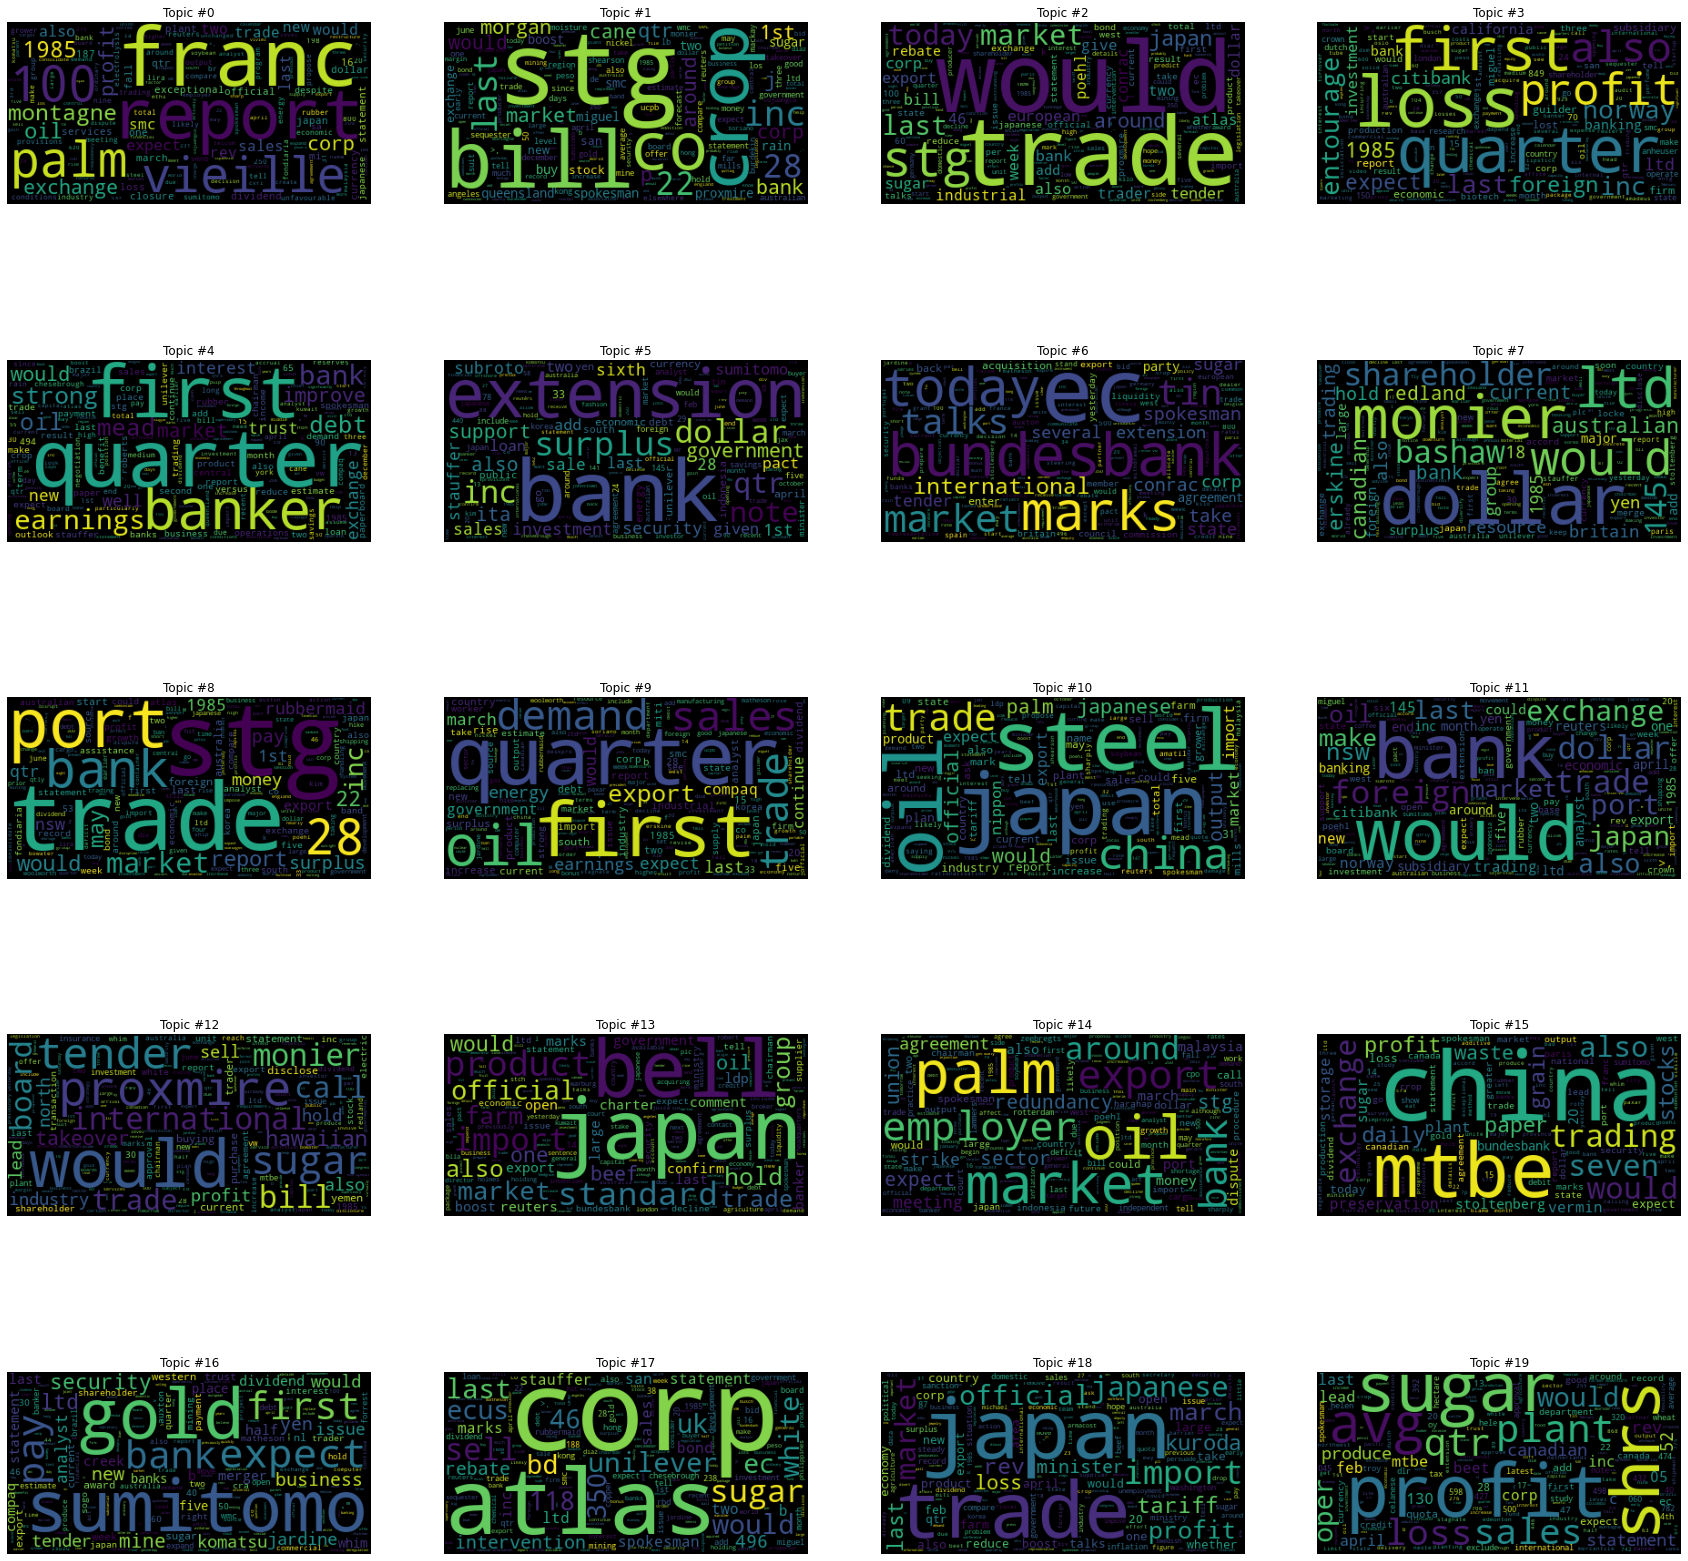

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
plt.figure(figsize=(30,30))
for t in range(ldamodel.num_topics):
    plt.subplot(5,4,t+1)
    x = dict(ldamodel.show_topic(t,200))
    im = WordCloud().generate_from_frequencies(x)
    plt.imshow(im)
    plt.axis("off")
    plt.title("Topic #" + str(t))

## パラメータの確認

In [ ]:
#(トピックID, 当該トピックにおける単語とそのprobability)  ※　のうち、上位num_words位 

topics = ldamodel.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.007*"franc" + 0.006*"report" + 0.006*"vieille" + 0.005*"100" + 0.005*"palm" + 0.005*"montagne" + 0.005*"1985" + 0.004*"oil" + 0.004*"exchange" + 0.004*"profit" + 0.004*"corp" + 0.004*"expect" + 0.004*"also" + 0.003*"last" + 0.003*"would"')
(1, '0.007*"stg" + 0.006*"bill" + 0.005*"crop" + 0.004*"co" + 0.004*"inc" + 0.004*"last" + 0.004*"28" + 0.004*"22" + 0.003*"morgan" + 0.003*"p" + 0.003*"market" + 0.003*"qtr" + 0.003*"j" + 0.003*"bank" + 0.003*"1st"')
(2, '0.008*"would" + 0.008*"trade" + 0.007*"stg" + 0.006*"today" + 0.006*"market" + 0.005*"last" + 0.005*"japan" + 0.005*"around" + 0.004*"european" + 0.004*"bill" + 0.004*"week" + 0.004*"corp" + 0.004*"bank" + 0.004*"tender" + 0.004*"export"')
(3, '0.008*"loss" + 0.007*"quarter" + 0.006*"first" + 0.006*"profit" + 0.005*"also" + 0.005*"norway" + 0.005*"last" + 0.005*"entourage" + 0.005*"inc" + 0.004*"foreign" + 0.004*"1985" + 0.004*"expect" + 0.004*"citibank" + 0.004*"ltd" + 0.003*"investment"')
(4, '0.010*"quarter" + 0.008*"firs

In [ ]:
#[(当該documentにおけるトピックIDとそのprobability　)]　 ※　のうち、minimum_probabilityの値を超えるもの

for n,item in enumerate(corpus_[:10]):
    print("document ID "+str(n)+":" ,end="")
    print(ldamodel.get_document_topics(item))

document ID 0:[(10, 0.2800171), (18, 0.71562374)]
document ID 1:[(15, 0.9666656)]
document ID 2:[(9, 0.9830345)]
document ID 3:[(9, 0.97978437)]
document ID 4:[(14, 0.980998)]
document ID 5:[(8, 0.32069334), (11, 0.66337615)]
document ID 6:[(2, 0.03805542), (11, 0.95434844)]
document ID 7:[(19, 0.94062066)]
document ID 8:[(16, 0.9728554)]
document ID 9:[(16, 0.99486405)]


In [ ]:
#documentのcategory
categories=[corpus.categories(fileid) for fileid in corpus.fileids()]

In [ ]:
n=0

#n番目のdocumentのトピック分布
print(ldamodel.get_document_topics(corpus_[n]))

#n番目のdocumentのcategory
print(categories[n])

#n番目のdocumentの生の文章
print(" ".join(docs[n]))

[(10, 0.2800118), (18, 0.7156291)]
['trade']
ASIAN EXPORTERS FEAR DAMAGE FROM U . S .- JAPAN RIFT Mounting trade friction between the U . S . And Japan has raised fears among many of Asia ' s exporting nations that the row could inflict far - reaching economic damage , businessmen and officials said . They told Reuter correspondents in Asian capitals a U . S . Move against Japan might boost protectionist sentiment in the U . S . And lead to curbs on American imports of their products . But some exporters said that while the conflict would hurt them in the long - run , in the short - term Tokyo ' s loss might be their gain . The U . S . Has said it will impose 300 mln dlrs of tariffs on imports of Japanese electronics goods on April 17 , in retaliation for Japan ' s alleged failure to stick to a pact not to sell semiconductors on world markets at below cost . Unofficial Japanese estimates put the impact of the tariffs at 10 billion dlrs and spokesmen for major electronics firms said the

In [ ]:
n=1

#n番目のdocumentのトピック分布
print(ldamodel.get_document_topics(corpus_[n]))

#n番目のdocumentのcategory
print(categories[n])

#n番目のdocumentの生の文章
print(" ".join(docs[n]))

[(15, 0.9666656)]
['grain']
CHINA DAILY SAYS VERMIN EAT 7 - 12 PCT GRAIN STOCKS A survey of 19 provinces and seven cities showed vermin consume between seven and 12 pct of China ' s grain stocks , the China Daily said . It also said that each year 1 . 575 mln tonnes , or 25 pct , of China ' s fruit output are left to rot , and 2 . 1 mln tonnes , or up to 30 pct , of its vegetables . The paper blamed the waste on inadequate storage and bad preservation methods . It said the government had launched a national programme to reduce waste , calling for improved technology in storage and preservation , and greater production of additives . The paper gave no further details .


In [ ]:
n=2

#n番目のdocumentのトピック分布
print(ldamodel.get_document_topics(corpus_[n]))

#n番目のdocumentのcategory
print(categories[n])

#n番目のdocumentの生の文章
print(" ".join(docs[n]))

[(9, 0.9830345)]
['crude', 'nat-gas']
JAPAN TO REVISE LONG - TERM ENERGY DEMAND DOWNWARDS The Ministry of International Trade and Industry ( MITI ) will revise its long - term energy supply / demand outlook by August to meet a forecast downtrend in Japanese energy demand , ministry officials said . MITI is expected to lower the projection for primary energy supplies in the year 2000 to 550 mln kilolitres ( kl ) from 600 mln , they said . The decision follows the emergence of structural changes in Japanese industry following the rise in the value of the yen and a decline in domestic electric power demand . MITI is planning to work out a revised energy supply / demand outlook through deliberations of committee meetings of the Agency of Natural Resources and Energy , the officials said . They said MITI will also review the breakdown of energy supply sources , including oil , nuclear , coal and natural gas . Nuclear energy provided the bulk of Japan ' s electric power in the fiscal year en

In [ ]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus_,
                                           num_topics=10,
                                           id2word=dictionary,
                                           alpha=0.1,                             #optional LDAのハイパーパラメータalpha
                                           eta=0.1,                                 #optional LDAのハイパーパラメータbeta
                                           #minimum_probability=0.0    #optional 学習結果に格納するトピック・単語の生起確率の下限
                                          )

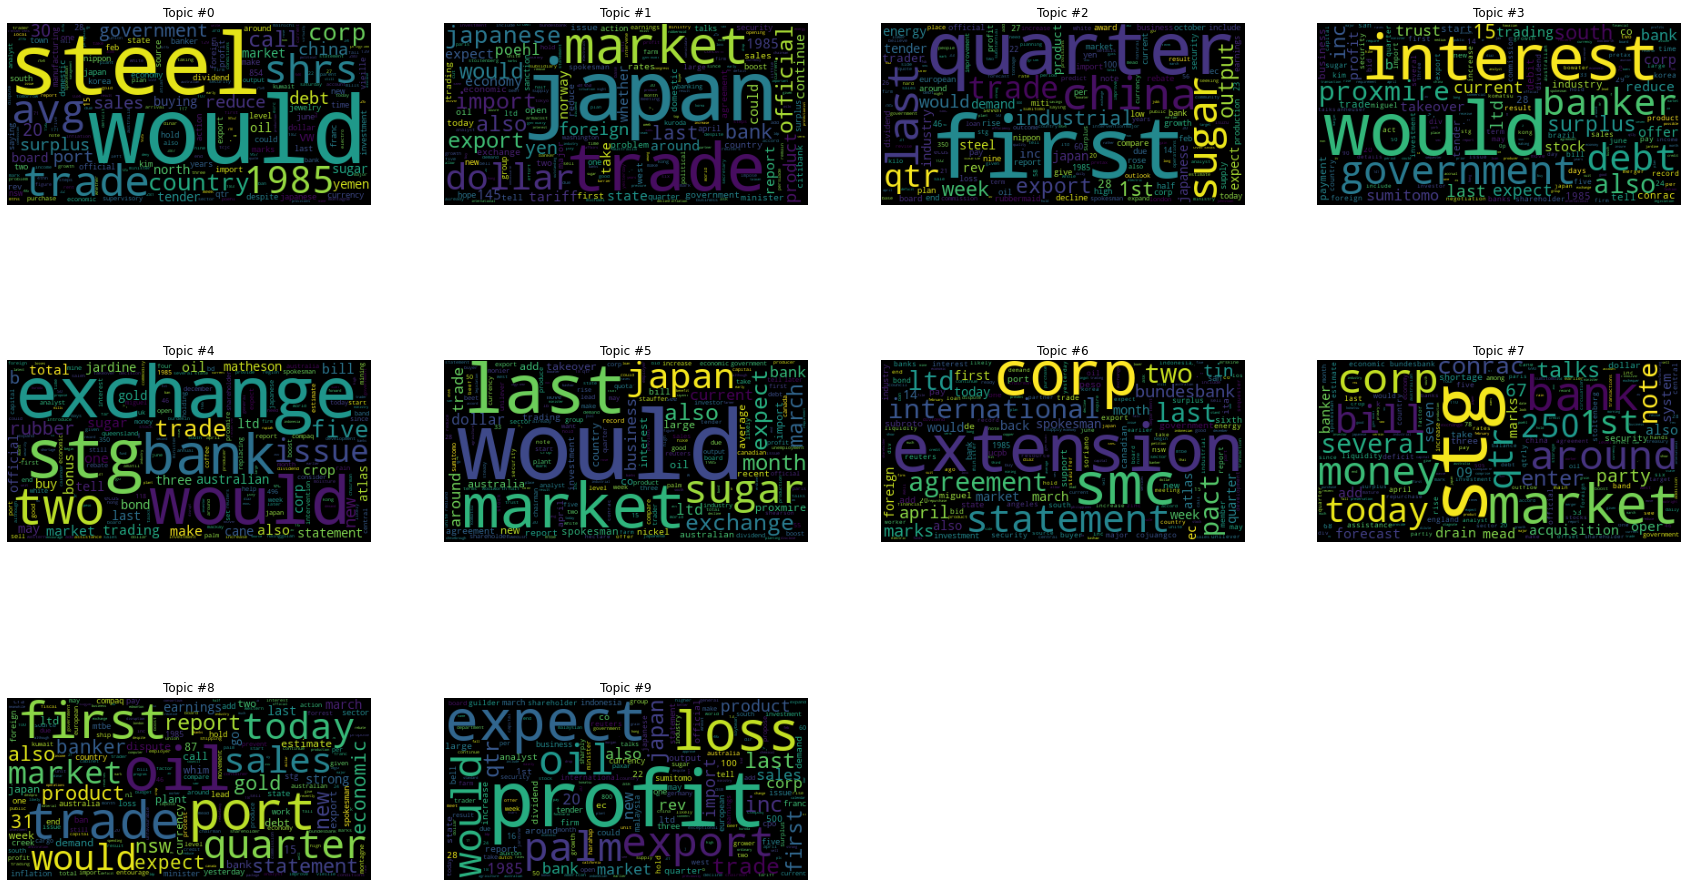

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
plt.figure(figsize=(30,30))
for t in range(ldamodel.num_topics):
    plt.subplot(5,4,t+1)
    x = dict(ldamodel.show_topic(t,200))
    im = WordCloud().generate_from_frequencies(x)
    plt.imshow(im)
    plt.axis("off")
    plt.title("Topic #" + str(t))

In [ ]:
#(トピックID, 当該トピックにおける単語とそのprobability)  ※　のうち、上位num_words位 

topics = ldamodel.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.006*"would" + 0.005*"steel" + 0.005*"trade" + 0.005*"avg" + 0.005*"shrs" + 0.004*"1985" + 0.004*"country" + 0.004*"corp" + 0.003*"call" + 0.003*"government" + 0.003*"surplus" + 0.003*"30" + 0.003*"debt" + 0.003*"20" + 0.003*"port"')
(1, '0.015*"japan" + 0.012*"trade" + 0.007*"market" + 0.007*"dollar" + 0.007*"japanese" + 0.006*"import" + 0.006*"official" + 0.006*"also" + 0.006*"export" + 0.006*"would" + 0.005*"bank" + 0.004*"last" + 0.004*"yen" + 0.004*"foreign" + 0.004*"product"')
(2, '0.009*"first" + 0.007*"quarter" + 0.006*"china" + 0.006*"last" + 0.005*"sugar" + 0.005*"qtr" + 0.005*"trade" + 0.004*"export" + 0.004*"output" + 0.004*"industrial" + 0.004*"week" + 0.004*"1st" + 0.004*"would" + 0.004*"energy" + 0.004*"rev"')
(3, '0.008*"would" + 0.006*"interest" + 0.005*"government" + 0.005*"banker" + 0.005*"debt" + 0.005*"proxmire" + 0.004*"also" + 0.004*"surplus" + 0.004*"15" + 0.004*"south" + 0.003*"inc" + 0.003*"expect" + 0.003*"last" + 0.003*"current" + 0.003*"ltd"')
(4, '0.

In [ ]:
#[(当該documentにおけるトピックIDとそのprobability　)]　 ※　のうち、minimum_probabilityの値を超えるもの

for n,item in enumerate(corpus_[:10]):
    print("document ID "+str(n)+":" ,end="")
    print(ldamodel.get_document_topics(item))

document ID 0:[(1, 0.9978152)]
document ID 1:[(7, 0.98392636)]
document ID 2:[(2, 0.99189085)]
document ID 3:[(2, 0.9903206)]
document ID 4:[(9, 0.9909082)]
document ID 5:[(8, 0.9919634)]
document ID 6:[(4, 0.99618596)]
document ID 7:[(9, 0.97096604)]
document ID 8:[(4, 0.9869546)]
document ID 9:[(5, 0.2194535), (9, 0.778378)]


In [ ]:
#documentのcategory
categories=[corpus.categories(fileid) for fileid in corpus.fileids()]

In [ ]:
n=0

#n番目のdocumentのトピック分布
print(ldamodel.get_document_topics(corpus_[n]))

#n番目のdocumentのcategory
print(categories[n])

#n番目のdocumentの生の文章
print(" ".join(docs[n]))

[(1, 0.9978152)]
['trade']
ASIAN EXPORTERS FEAR DAMAGE FROM U . S .- JAPAN RIFT Mounting trade friction between the U . S . And Japan has raised fears among many of Asia ' s exporting nations that the row could inflict far - reaching economic damage , businessmen and officials said . They told Reuter correspondents in Asian capitals a U . S . Move against Japan might boost protectionist sentiment in the U . S . And lead to curbs on American imports of their products . But some exporters said that while the conflict would hurt them in the long - run , in the short - term Tokyo ' s loss might be their gain . The U . S . Has said it will impose 300 mln dlrs of tariffs on imports of Japanese electronics goods on April 17 , in retaliation for Japan ' s alleged failure to stick to a pact not to sell semiconductors on world markets at below cost . Unofficial Japanese estimates put the impact of the tariffs at 10 billion dlrs and spokesmen for major electronics firms said they would virtually 

In [ ]:
n=1

#n番目のdocumentのトピック分布
print(ldamodel.get_document_topics(corpus_[n]))

#n番目のdocumentのcategory
print(categories[n])

#n番目のdocumentの生の文章
print(" ".join(docs[n]))

[(7, 0.98392636)]
['grain']
CHINA DAILY SAYS VERMIN EAT 7 - 12 PCT GRAIN STOCKS A survey of 19 provinces and seven cities showed vermin consume between seven and 12 pct of China ' s grain stocks , the China Daily said . It also said that each year 1 . 575 mln tonnes , or 25 pct , of China ' s fruit output are left to rot , and 2 . 1 mln tonnes , or up to 30 pct , of its vegetables . The paper blamed the waste on inadequate storage and bad preservation methods . It said the government had launched a national programme to reduce waste , calling for improved technology in storage and preservation , and greater production of additives . The paper gave no further details .


In [ ]:
n=2

#n番目のdocumentのトピック分布
print(ldamodel.get_document_topics(corpus_[n]))

#n番目のdocumentのcategory
print(categories[n])

#n番目のdocumentの生の文章
print(" ".join(docs[n]))

[(2, 0.99189085)]
['crude', 'nat-gas']
JAPAN TO REVISE LONG - TERM ENERGY DEMAND DOWNWARDS The Ministry of International Trade and Industry ( MITI ) will revise its long - term energy supply / demand outlook by August to meet a forecast downtrend in Japanese energy demand , ministry officials said . MITI is expected to lower the projection for primary energy supplies in the year 2000 to 550 mln kilolitres ( kl ) from 600 mln , they said . The decision follows the emergence of structural changes in Japanese industry following the rise in the value of the yen and a decline in domestic electric power demand . MITI is planning to work out a revised energy supply / demand outlook through deliberations of committee meetings of the Agency of Natural Resources and Energy , the officials said . They said MITI will also review the breakdown of energy supply sources , including oil , nuclear , coal and natural gas . Nuclear energy provided the bulk of Japan ' s electric power in the fiscal year e

In [ ]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus_,
                                           num_topics=5,
                                           id2word=dictionary,
                                           alpha=0.1,                             #optional LDAのハイパーパラメータalpha
                                           eta=0.1,                                 #optional LDAのハイパーパラメータbeta
                                           #minimum_probability=0.0    #optional 学習結果に格納するトピック・単語の生起確率の下限
                                          )

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

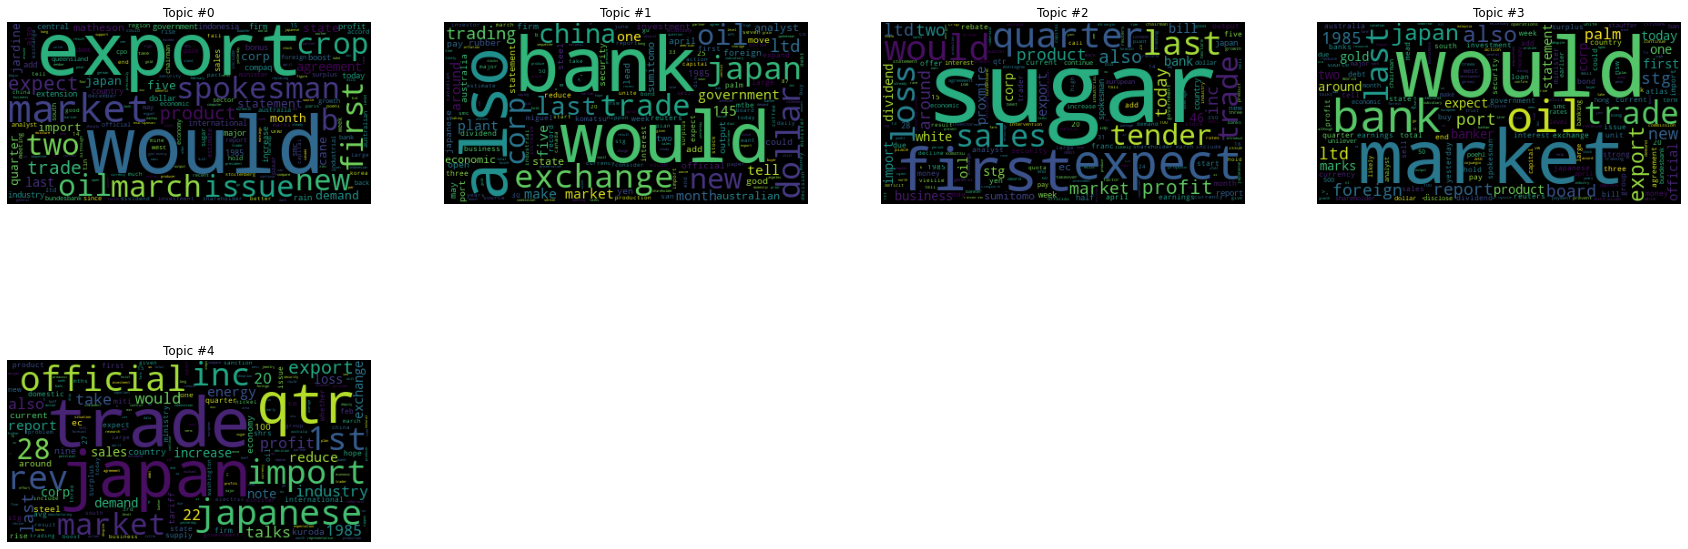

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
plt.figure(figsize=(30,30))
for t in range(ldamodel.num_topics):
    plt.subplot(5,4,t+1)
    x = dict(ldamodel.show_topic(t,200))
    im = WordCloud().generate_from_frequencies(x)
    plt.imshow(im)
    plt.axis("off")
    plt.title("Topic #" + str(t))

In [ ]:
#(トピックID, 当該トピックにおける単語とそのprobability)  ※　のうち、上位num_words位 

topics = ldamodel.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.006*"would" + 0.005*"export" + 0.005*"market" + 0.004*"spokesman" + 0.004*"oil" + 0.004*"issue" + 0.004*"crop" + 0.004*"march" + 0.004*"first" + 0.004*"two" + 0.004*"b" + 0.004*"new" + 0.004*"expect" + 0.004*"product" + 0.004*"trade"')
(1, '0.008*"bank" + 0.007*"would" + 0.006*"also" + 0.006*"exchange" + 0.006*"japan" + 0.006*"dollar" + 0.005*"trade" + 0.005*"new" + 0.005*"oil" + 0.004*"corp" + 0.004*"china" + 0.004*"last" + 0.004*"trading" + 0.004*"ltd" + 0.004*"government"')
(2, '0.007*"sugar" + 0.007*"first" + 0.007*"expect" + 0.007*"quarter" + 0.006*"would" + 0.005*"last" + 0.005*"loss" + 0.005*"sales" + 0.005*"tender" + 0.005*"trade" + 0.004*"profit" + 0.004*"also" + 0.004*"product" + 0.004*"inc" + 0.004*"market"')
(3, '0.008*"would" + 0.007*"market" + 0.006*"bank" + 0.005*"oil" + 0.005*"trade" + 0.005*"last" + 0.005*"japan" + 0.004*"also" + 0.004*"export" + 0.004*"foreign" + 0.004*"1985" + 0.004*"report" + 0.004*"port" + 0.004*"ltd" + 0.003*"board"')
(4, '0.012*"trade" + 0

In [ ]:
#[(当該documentにおけるトピックIDとそのprobability　)]　 ※　のうち、minimum_probabilityの値を超えるもの

for n,item in enumerate(corpus_[:10]):
    print("document ID "+str(n)+":" ,end="")
    print(ldamodel.get_document_topics(item))

document ID 0:[(3, 0.16529314), (4, 0.8337393)]
document ID 1:[(1, 0.99279237)]
document ID 2:[(4, 0.9963795)]
document ID 3:[(2, 0.995675)]
document ID 4:[(0, 0.9959385)]
document ID 5:[(3, 0.99641204)]
document ID 6:[(1, 0.9983012)]
document ID 7:[(3, 0.98688346)]
document ID 8:[(0, 0.9941596)]
document ID 9:[(1, 0.7840906), (2, 0.21509524)]


In [ ]:
#documentのcategory
categories=[corpus.categories(fileid) for fileid in corpus.fileids()]

In [ ]:
n=0

#n番目のdocumentのトピック分布
print(ldamodel.get_document_topics(corpus_[n]))

#n番目のdocumentのcategory
print(categories[n])

#n番目のdocumentの生の文章
print(" ".join(docs[n]))

[(3, 0.16501483), (4, 0.8337541)]
['trade']
ASIAN EXPORTERS FEAR DAMAGE FROM U . S .- JAPAN RIFT Mounting trade friction between the U . S . And Japan has raised fears among many of Asia ' s exporting nations that the row could inflict far - reaching economic damage , businessmen and officials said . They told Reuter correspondents in Asian capitals a U . S . Move against Japan might boost protectionist sentiment in the U . S . And lead to curbs on American imports of their products . But some exporters said that while the conflict would hurt them in the long - run , in the short - term Tokyo ' s loss might be their gain . The U . S . Has said it will impose 300 mln dlrs of tariffs on imports of Japanese electronics goods on April 17 , in retaliation for Japan ' s alleged failure to stick to a pact not to sell semiconductors on world markets at below cost . Unofficial Japanese estimates put the impact of the tariffs at 10 billion dlrs and spokesmen for major electronics firms said they

In [ ]:
n=1

#n番目のdocumentのトピック分布
print(ldamodel.get_document_topics(corpus_[n]))

#n番目のdocumentのcategory
print(categories[n])

#n番目のdocumentの生の文章
print(" ".join(docs[n]))

[(1, 0.99279237)]
['grain']
CHINA DAILY SAYS VERMIN EAT 7 - 12 PCT GRAIN STOCKS A survey of 19 provinces and seven cities showed vermin consume between seven and 12 pct of China ' s grain stocks , the China Daily said . It also said that each year 1 . 575 mln tonnes , or 25 pct , of China ' s fruit output are left to rot , and 2 . 1 mln tonnes , or up to 30 pct , of its vegetables . The paper blamed the waste on inadequate storage and bad preservation methods . It said the government had launched a national programme to reduce waste , calling for improved technology in storage and preservation , and greater production of additives . The paper gave no further details .


In [ ]:
n=2

#n番目のdocumentのトピック分布
print(ldamodel.get_document_topics(corpus_[n]))

#n番目のdocumentのcategory
print(categories[n])

#n番目のdocumentの生の文章
print(" ".join(docs[n]))

[(4, 0.9963795)]
['crude', 'nat-gas']
JAPAN TO REVISE LONG - TERM ENERGY DEMAND DOWNWARDS The Ministry of International Trade and Industry ( MITI ) will revise its long - term energy supply / demand outlook by August to meet a forecast downtrend in Japanese energy demand , ministry officials said . MITI is expected to lower the projection for primary energy supplies in the year 2000 to 550 mln kilolitres ( kl ) from 600 mln , they said . The decision follows the emergence of structural changes in Japanese industry following the rise in the value of the yen and a decline in domestic electric power demand . MITI is planning to work out a revised energy supply / demand outlook through deliberations of committee meetings of the Agency of Natural Resources and Energy , the officials said . They said MITI will also review the breakdown of energy supply sources , including oil , nuclear , coal and natural gas . Nuclear energy provided the bulk of Japan ' s electric power in the fiscal year en

## 可視化

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [ ]:
#全documentを学習に用いた場合結構時間がかかる(20min~)
#gensimではK個のトピックに0~K-1のidが割り振られていたのに対し，pyLDAvisでは1~Kのidが割り振られていることに注意

lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus_, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [ ]:
#上で可視化したモデルをgoogle drive上にsaveできる

pyLDAvis.save_html(lda_display,'vis.html')

In [ ]:
!ls

sample_data  vis.html
